# Table of Content:
**Part 1 : Setting up the Big Data environment**
 - <a href="#C1">Importing libraries</a>
 - <a href="#C2">Defining functions</a>
 - <a href="#C3">Loading the dataset</a>
 
**Partie 2 : Data classification**
 - <a href="#C4">Preprocessing and features extraction</a>
 - <a href="#C5">Modeling and visualisation</a>

In [1]:
#requirements.txt or
#pip install boto3
#pip install pandas
#pip install matplotlib
#pip install seaborn
#pip install opencv-python
#pip install sklearn
#pip install tensorflow
#pip install imageio
#pip install pyspark

# Part 1 : Setting up the Big Data environment

# <a name="C1">Importing libraries</a>

In [2]:
# Python standard libraries
import pandas as pd
import numpy as np
import io
from io import BytesIO
import boto3
import cv2
import matplotlib.pyplot as plt 
import imageio
import itertools
import pyspark
import random
import time
from PIL import Image, ImageOps
import seaborn as sns
from functools import reduce
from numpy import array
from math import sqrt

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

2022-08-26 06:43:08.749506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/pyenv/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-26 06:43:08.749546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Pyspark (big data) libraries
import findspark
findspark.init()

import pyspark

from pyspark import SparkContext, SparkConf, SQLContext, Row

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import col, split, lit, pandas_udf, PandasUDFType, udf, concat_ws
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType

from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import StandardScaler, PCA, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.clustering import KMeans, KMeansModel

# <a name="C1">Defining functions</a>

In [4]:
'''Function to convert types'''
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
vector_to_array = udf(lambda x: x.toArray().tolist(), ArrayType(FloatType()))

In [5]:
def get_spark_df(s3, bucket_name):
    
    '''Function to create the spark dataframe with pictures and associate label'''
    img_path = []
    for img in s3.list_objects(Bucket=bucket_name)['Contents']:
        if "jpg" in img['Key']:
            img_path.append(img['Key'])
    img_path = map(lambda x : Row(x), img_path)
    df = spark.createDataFrame(img_path, ['img_path'])
    df = df.withColumn('label', split(df['img_path'], '/').getItem(0))
    
    return df

In [6]:
def get_img(bucket_name, key_name):

    '''Function to see the image'''
    with BytesIO() as f:
        boto3.client("s3").download_fileobj(Bucket=bucket_name, Key=key_name, Fileobj=f)
        f.seek(0)
        img = plt.imread(f, format='jpg')

    return img

In [7]:
def get_features(s3C, s3R, bucket_name, model):

    '''Function to create features for each image using a model'''
    model_features = []
    bucket = s3R.Bucket(bucket_name)
    for img in s3C.list_objects(Bucket=bucket_name)['Contents']:
        if "jpg" in img['Key']:
            obj = bucket.Object(img['Key'])
            img_body = obj.get()['Body']
            img = Image.open(img_body)
            img = img.resize((224, 224))
            img = np.expand_dims(img, axis=0)
            img_pp = preprocess_input(img)
            model_feature = model.predict(img_pp).ravel().tolist()
            model_features.append(model_feature)
    df_features = spark.createDataFrame([(f,) for f in model_features], ['features'])
           
    return df_features

In [8]:
def plot_TSNE(data_pca, data_kmeans, list_cat):
    
    '''Function to see the TSNE projection of actual categories and clusters'''

    tsne = TSNE(n_components=2, perplexity=20, n_iter=2000, init='random', learning_rate=200, random_state=42)
    df_tsne_p = tsne.fit_transform(data_pca)

    df_tsne_p=pd.DataFrame(df_tsne_p, columns=['tsne1', 'tsne2'])

    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(df_tsne_p['tsne1'], df_tsne_p['tsne2'], c=data_pca.category, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list_cat, loc="best", title="Categorie")
    plt.title('TSNE Visualisation by actual categories')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(df_tsne_p['tsne1'], df_tsne_p['tsne2'], c=data_kmeans.prediction, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(data_kmeans.prediction), loc="best", title="Clusters")
    plt.title('TSNE Visualisation by clusters')
    
    plt.show()

In [9]:
def plot_confusion_mat(df_test, classes):
    
    '''Function to see the confusion matrix'''
    y_true = df_test.select("category")
    y_true = y_true.toPandas()

    y_pred = df_test.select("prediction")
    y_pred = y_pred.toPandas()
    
    sns.set_style("darkgrid")

    plt.figure(figsize=(7,7))
    plt.grid(False)

    cm = confusion_matrix(y_true, y_pred,labels=classes)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# <a name="C1">Loading the Dataset</a>

In [11]:
# Creating access to S3 data
session = boto3.Session()
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()
ACCESS_KEY = credentials.access_key
SECRET_KEY = credentials.secret_key
s3C = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
s3R = boto3.resource('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
BUCKET_NAME = 'najfruits360ext'

In [12]:
# Initialising the Spark session
spark = SparkSession.builder.master('local[*]').appName('P8').config("spark.driver.memory", "16g").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/26 06:43:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
# Importing the dataset to a spark dataframe - check of first rows
df = get_spark_df(s3C, BUCKET_NAME)
df.show()

+--------------------+--------------+
|            img_path|         label|
+--------------------+--------------+
|Apple_Braeburn/0_...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/10...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
|Apple_Braeburn/11...|Apple_Braeburn|
+--------------------+--------------+
only showing top 20 rows



In [14]:
# Displaying the dataframe shape
(df.count() , len(df.columns))

(928, 2)

In [15]:
# Displaying the number of pictures per category
df.groupBy('label').count().show()
#print()

+---------------+-----+
|          label|count|
+---------------+-----+
| Apple_Braeburn|  246|
|Apple_Pink_Lady|  228|
|            Fig|  234|
|           Kiwi|  220|
+---------------+-----+



In [16]:
# Displaying the dataframe structure 
df.printSchema()

root
 |-- img_path: string (nullable = true)
 |-- label: string (nullable = true)



(-0.5, 99.5, 99.5, -0.5)

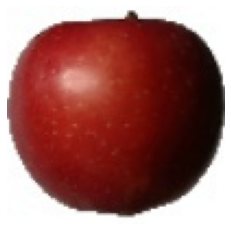

In [17]:
# Displaying the second picture of the dataset
image = get_img(BUCKET_NAME, df.take(2)[1][0])
plt.imshow(image)
plt.axis('off')

# Part 2 : Images classification

# <a name="C1">Preprocessing and Features Extraction</a>

### Preprocessing and features extraction with VGG16

In [18]:
# Loading the CNN model VGG16 used for features extraction
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output) #We delete last layer
model.summary()

2022-08-26 06:43:30.131850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/pyenv/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-26 06:43:30.131894: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 06:43:30.131921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-28-200): /proc/driver/nvidia/version does not exist
2022-08-26 06:43:30.132994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Computing features resulting from the above model
df_features = get_features(s3C, s3R, BUCKET_NAME, model)
df_features.show()

1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 338ms/step
22/08/26 06:50:03 WARN TaskSetManager: Stage 8 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+
|            features|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 3...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 1...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 2...|
|[0.0, 0.0, 0.0, 3...|
|[0.0, 0.0, 0.0, 3...|
|[0.0, 0.0, 0.0, 3...|
|[0.0, 0.0, 0.0, 3...|
|[0.0, 0.100522607...|
+--------------------+
only showing top 20 rows




[Stage 8:>                                                          (0 + 1) / 1]



In [20]:
# Merging features with dataframe containing the fruit/veg data
df = df.select("*").withColumn("index", F.monotonically_increasing_id())
df_features = df_features.select("*").withColumn("index", F.monotonically_increasing_id())
df = df_features.join(df, on=['index'], how='full').drop('index')
df = df.select('label', array_to_vector('features').alias('features_vec'))
df.show()

22/08/26 06:50:04 WARN TaskSetManager: Stage 9 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------------+--------------------+
|         label|        features_vec|
+--------------+--------------------+
|Apple_Braeburn|[0.0,0.0,0.0,0.55...|
|Apple_Braeburn|[0.0,0.0,0.0,2.22...|
|Apple_Braeburn|[0.0,0.0,0.0,2.91...|
|Apple_Braeburn|[0.0,0.0,0.0,2.87...|
|Apple_Braeburn|[0.0,0.0,0.0,2.48...|
|Apple_Braeburn|[0.0,0.0,0.0,2.83...|
|Apple_Braeburn|[0.0,0.0,0.0,2.79...|
|Apple_Braeburn|[0.0,0.0,0.0,3.17...|
|Apple_Braeburn|[0.0,0.1005226075...|
|Apple_Braeburn|[0.0,0.0,0.0,1.74...|
|Apple_Braeburn|[0.0,0.0,0.0,3.19...|
|Apple_Braeburn|[0.0,0.0938909053...|
|Apple_Braeburn|[0.0,0.0,0.0,2.73...|
|Apple_Braeburn|[0.0,0.0,0.0,2.25...|
|Apple_Braeburn|[0.0,0.0,0.0,2.00...|
|Apple_Braeburn|[0.0,0.0,0.0,2.33...|
|Apple_Braeburn|[0.0,0.1395691335...|
|Apple_Braeburn|[0.0,0.0,0.0,1.18...|
|Apple_Braeburn|[0.0,0.0,0.0,2.91...|
|Apple_Braeburn|[0.0,0.1426188647...|
+--------------+--------------------+
only showing top 20 rows



# <a name="C1">Dimension Reduction</a>

### Label transformation

In [21]:
# Displaying types
df.dtypes

[('label', 'string'), ('features_vec', 'vector')]

In [22]:
# Indexing labels - by order 
indexer = StringIndexer(inputCol='label', outputCol='label_numeric', stringOrderType ='alphabetAsc')
df_si = indexer.fit(df).transform(df)
df_si = df_si.select('label_numeric', 'features_vec')
df_si = df_si.withColumnRenamed("label_numeric","category")
df_si.show()

22/08/26 06:50:10 WARN TaskSetManager: Stage 14 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:50:13 WARN TaskSetManager: Stage 23 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+
|category|        features_vec|
+--------+--------------------+
|     0.0|[0.0,0.0,0.0,0.55...|
|     0.0|[0.0,0.0,0.0,2.22...|
|     0.0|[0.0,0.0,0.0,2.91...|
|     0.0|[0.0,0.0,0.0,2.87...|
|     0.0|[0.0,0.0,0.0,2.48...|
|     0.0|[0.0,0.0,0.0,2.83...|
|     0.0|[0.0,0.0,0.0,2.79...|
|     0.0|[0.0,0.0,0.0,3.17...|
|     0.0|[0.0,0.1005226075...|
|     0.0|[0.0,0.0,0.0,1.74...|
|     0.0|[0.0,0.0,0.0,3.19...|
|     0.0|[0.0,0.0938909053...|
|     0.0|[0.0,0.0,0.0,2.73...|
|     0.0|[0.0,0.0,0.0,2.25...|
|     0.0|[0.0,0.0,0.0,2.00...|
|     0.0|[0.0,0.0,0.0,2.33...|
|     0.0|[0.0,0.1395691335...|
|     0.0|[0.0,0.0,0.0,1.18...|
|     0.0|[0.0,0.0,0.0,2.91...|
|     0.0|[0.0,0.1426188647...|
+--------+--------------------+
only showing top 20 rows



In [23]:
# Displaying resulting types
df.dtypes

[('label', 'string'), ('features_vec', 'vector')]

### Dimension reduction with PCA

In [24]:
# Scaling features before PCA
scaler = StandardScaler(inputCol='features_vec', outputCol='features')
scaler_model = scaler.fit(df_si)
df_sc = scaler_model.transform(df_si)
df_sc = df_sc.select('category', 'features')
df_sc.show()

22/08/26 06:50:17 WARN TaskSetManager: Stage 28 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:50:24 WARN TaskSetManager: Stage 37 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+
|category|            features|
+--------+--------------------+
|     0.0|[0.0,0.0,0.0,0.49...|
|     0.0|[0.0,0.0,0.0,1.95...|
|     0.0|[0.0,0.0,0.0,2.56...|
|     0.0|[0.0,0.0,0.0,2.53...|
|     0.0|[0.0,0.0,0.0,2.19...|
|     0.0|[0.0,0.0,0.0,2.50...|
|     0.0|[0.0,0.0,0.0,2.46...|
|     0.0|[0.0,0.0,0.0,2.79...|
|     0.0|[0.0,0.4821518645...|
|     0.0|[0.0,0.0,0.0,1.53...|
|     0.0|[0.0,0.0,0.0,2.81...|
|     0.0|[0.0,0.4503432231...|
|     0.0|[0.0,0.0,0.0,2.41...|
|     0.0|[0.0,0.0,0.0,1.98...|
|     0.0|[0.0,0.0,0.0,1.77...|
|     0.0|[0.0,0.0,0.0,2.06...|
|     0.0|[0.0,0.6694366530...|
|     0.0|[0.0,0.0,0.0,1.04...|
|     0.0|[0.0,0.0,0.0,2.56...|
|     0.0|[0.0,0.6840645426...|
+--------+--------------------+
only showing top 20 rows



In [25]:
# Applying PCA to the features - 100 dimensions
pca100 = PCA(k=100, inputCol="features", outputCol="features_pca")
pca100_model = pca100.fit(df_sc)
df_pca100 = pca100_model.transform(df_sc).select("category", "features_pca")
df_pca100.show()

22/08/26 06:50:27 WARN TaskSetManager: Stage 42 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:50:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/26 06:50:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/08/26 06:50:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/08/26 06:50:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/08/26 06:54:14 WARN TaskSetManager: Stage 62 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:54:17 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


+--------+--------------------+
|category|        features_pca|
+--------+--------------------+
|     0.0|[3.51591850674599...|
|     0.0|[0.68652618962347...|
|     0.0|[1.04571548325630...|
|     0.0|[2.37953706247352...|
|     0.0|[2.28412267169469...|
|     0.0|[2.91693325130501...|
|     0.0|[2.55720716273707...|
|     0.0|[4.45190113936831...|
|     0.0|[3.09944003263898...|
|     0.0|[3.45551328585190...|
|     0.0|[2.60466133300464...|
|     0.0|[1.96788937466830...|
|     0.0|[2.01581102339301...|
|     0.0|[1.76657095279812...|
|     0.0|[2.45296961093089...|
|     0.0|[2.58552367429034...|
|     0.0|[2.61286942980344...|
|     0.0|[2.54925312709113...|
|     0.0|[2.18788313647573...|
|     0.0|[1.58638143967728...|
+--------+--------------------+
only showing top 20 rows



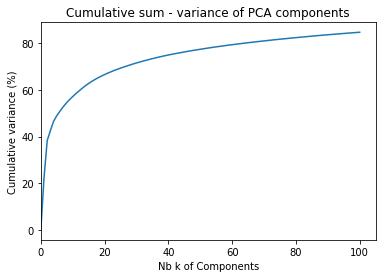

In [26]:
# Displaying PCA variance
var = pca100_model.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(100+1)], 
             y=np.insert(var, 0, 0)*100)
plt.title('Cumulative sum - variance of PCA components')
plt.xlim(left=0)
plt.xlabel('Nb k of Components')
plt.ylabel('Cumulative variance (%)')
plt.show()

In [27]:
# Applying PCA to features - 10 dimensions
pca10 = PCA(k=10, inputCol="features", outputCol="features_pca")
pca10_model = pca10.fit(df_sc)
df_pca10 = pca10_model.transform(df_sc).select("category", "features_pca")
df_pca10.show()

22/08/26 06:54:19 WARN TaskSetManager: Stage 67 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:58:02 WARN TaskSetManager: Stage 87 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+
|category|        features_pca|
+--------+--------------------+
|     0.0|[3.51591850674599...|
|     0.0|[0.68652618962347...|
|     0.0|[1.04571548325630...|
|     0.0|[2.37953706247352...|
|     0.0|[2.28412267169469...|
|     0.0|[2.91693325130501...|
|     0.0|[2.55720716273707...|
|     0.0|[4.45190113936831...|
|     0.0|[3.09944003263898...|
|     0.0|[3.45551328585190...|
|     0.0|[2.60466133300464...|
|     0.0|[1.96788937466830...|
|     0.0|[2.01581102339301...|
|     0.0|[1.76657095279812...|
|     0.0|[2.45296961093089...|
|     0.0|[2.58552367429034...|
|     0.0|[2.61286942980344...|
|     0.0|[2.54925312709113...|
|     0.0|[2.18788313647573...|
|     0.0|[1.58638143967728...|
+--------+--------------------+
only showing top 20 rows



# <a name="C6">Modeling</a>

### Spliting train and test data  

In [28]:
# Spliting train and test data
train, test = df_pca10.randomSplit([0.8, 0.2], 42)
print(f"Train set length: {train.count()} records")
print(f"Test set length: {test.count()} records")

22/08/26 06:58:05 WARN TaskSetManager: Stage 92 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


Train set length: 762 records
22/08/26 06:58:10 WARN TaskSetManager: Stage 101 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


Test set length: 166 records


### Modeling with Kmeans

In [29]:
# Defining the number of clusters
nb_cluster = df_pca10.select("category").distinct().count()

22/08/26 06:58:15 WARN TaskSetManager: Stage 110 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


In [30]:
# Building the clustering model
kmeans = KMeans(featuresCol='features_pca', k=nb_cluster, seed=1)
k_model = kmeans.fit(train)
df_k = k_model.transform(df_pca10)
df_k.show()

22/08/26 06:58:17 WARN TaskSetManager: Stage 124 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:58:18 WARN TaskSetManager: Stage 126 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:58:30 WARN TaskSetManager: Stage 178 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:58:35 WARN TaskSetManager: Stage 187 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+----------+
|category|        features_pca|prediction|
+--------+--------------------+----------+
|     0.0|[3.51591850674599...|         1|
|     0.0|[0.68652618962347...|         0|
|     0.0|[1.04571548325630...|         0|
|     0.0|[2.37953706247352...|         0|
|     0.0|[2.28412267169469...|         0|
|     0.0|[2.91693325130501...|         0|
|     0.0|[2.55720716273707...|         0|
|     0.0|[4.45190113936831...|         0|
|     0.0|[3.09944003263898...|         0|
|     0.0|[3.45551328585190...|         1|
|     0.0|[2.60466133300464...|         0|
|     0.0|[1.96788937466830...|         0|
|     0.0|[2.01581102339301...|         0|
|     0.0|[1.76657095279812...|         0|
|     0.0|[2.45296961093089...|         0|
|     0.0|[2.58552367429034...|         0|
|     0.0|[2.61286942980344...|         0|
|     0.0|[2.54925312709113...|         1|
|     0.0|[2.18788313647573...|         0|
|     0.0|[1.58638143967728...|         0|
+--------+-


[Stage 191:>                                                        (0 + 1) / 1]



### TSNE Visualisation 

In [31]:
# Displaying dataframe types
df_pca10.dtypes

[('category', 'double'), ('features_pca', 'vector')]

In [32]:
# Transforming vertor to array
df_pca_arr = df_pca10.select('category', vector_to_array('features_pca').alias('features_arr'))
df_pca_arr.dtypes

[('category', 'double'), ('features_arr', 'array<float>')]

In [33]:
# Transforming array to string
df_pca_arr = df_pca_arr.withColumn("features_arr", concat_ws(",",col("features_arr")))
df_pca_arr.show()

22/08/26 06:58:37 WARN TaskSetManager: Stage 192 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+
|category|        features_arr|
+--------+--------------------+
|     0.0|3.5159185,-13.840...|
|     0.0|0.6865262,-18.690...|
|     0.0|1.0457155,-18.400...|
|     0.0|2.379537,-19.1607...|
|     0.0|2.2841227,-17.873...|
|     0.0|2.9169333,-17.673...|
|     0.0|2.557207,-17.7595...|
|     0.0|4.451901,-18.8528...|
|     0.0|3.09944,-18.42372...|
|     0.0|3.4555132,-15.036...|
|     0.0|2.6046612,-19.071...|
|     0.0|1.9678894,-18.743...|
|     0.0|2.015811,-18.7439...|
|     0.0|1.7665709,-19.690...|
|     0.0|2.4529696,-18.962...|
|     0.0|2.5855236,-18.386...|
|     0.0|2.6128695,-19.548...|
|     0.0|2.5492532,-15.524...|
|     0.0|2.1878831,-19.324...|
|     0.0|1.5863814,-18.390...|
+--------+--------------------+
only showing top 20 rows



In [34]:
# Spliting features column into separate columns
split_cols = pyspark.sql.functions.split(df_pca_arr['features_arr'], ',')
df_pca_split = df_pca_arr.withColumn('pca_1', split_cols.getItem(0)).withColumn('pca_2', split_cols.getItem(1)).withColumn('pca_3', split_cols.getItem(2)).withColumn('pca_4', split_cols.getItem(3)).withColumn('pca_5', split_cols.getItem(4)).withColumn('pca_6', split_cols.getItem(5)).withColumn('pca_7', split_cols.getItem(6)).withColumn('pca_8', split_cols.getItem(7)).withColumn('pca_9', split_cols.getItem(8)).withColumn('pca_10', split_cols.getItem(9))  
df_pca_split = df_pca_split.select('category', 'pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7','pca_8','pca_9','pca_10')
df_pca_split.show()

22/08/26 06:58:41 WARN TaskSetManager: Stage 197 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+---------+----------+---------+----------+---------+----------+------------+---------+-----------+----------+
|category|    pca_1|     pca_2|    pca_3|     pca_4|    pca_5|     pca_6|       pca_7|    pca_8|      pca_9|    pca_10|
+--------+---------+----------+---------+----------+---------+----------+------------+---------+-----------+----------+
|     0.0|3.5159185|-13.840012| 17.97398| -4.333234|3.4662387| 1.5640634|  -4.3323736|4.1601367|   2.996607|-13.397824|
|     0.0|0.6865262| -18.69013|12.367981|  9.587235| 4.900906|-2.7080915|   0.7293765|11.286498|  1.7270184|-10.619316|
|     0.0|1.0457155|-18.400942| 8.391715| 13.806334|6.0572586| -4.126445|   0.8356612|13.635714|  0.8304759|-10.813998|
|     0.0| 2.379537|-19.160788| 9.541322| 18.460112|6.2921977|-4.0997014|   1.8227208|14.184783| 0.93862504| -9.818209|
|     0.0|2.2841227|-17.873192| 8.790071| 11.858202|6.1414914|-4.2553577| -0.90065706|14.497368|  2.2946582|-11.576937|
|     0.0|2.9169333|-17.673954| 7.975356

In [35]:
# Listing labels by order
list_cat = [i.label for i in df.select('label').distinct().collect()]
list_cat

22/08/26 06:58:45 WARN TaskSetManager: Stage 202 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


['Apple_Braeburn', 'Apple_Pink_Lady', 'Fig', 'Kiwi']

22/08/26 06:58:46 WARN TaskSetManager: Stage 211 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:58:53 WARN TaskSetManager: Stage 216 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


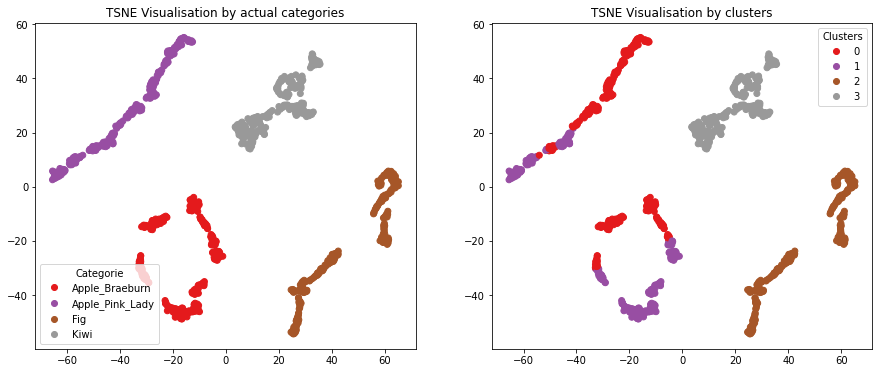

In [36]:
# Visualising TSNE
df_pca_split_p = df_pca_split.toPandas()
df_k_p = df_k.toPandas()

plot_TSNE(df_pca_split_p, df_k_p, list_cat)

### Visualisation - Confusion Matrix

In [37]:
# Predicting the test data
pred_test = k_model.transform(test)
pred_test.show()

22/08/26 06:59:05 WARN TaskSetManager: Stage 221 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+----------+
|category|        features_pca|prediction|
+--------+--------------------+----------+
|     0.0|[-1.5243733051655...|         1|
|     0.0|[-1.1491872928059...|         0|
|     0.0|[-0.8216026875691...|         1|
|     0.0|[0.15070027373585...|         0|
|     0.0|[0.65358753947288...|         0|
|     0.0|[0.80477694497027...|         1|
|     0.0|[1.03938455346944...|         1|
|     0.0|[1.33323246638662...|         0|
|     0.0|[1.79161823828759...|         1|
|     0.0|[1.85031217294839...|         1|
|     0.0|[1.86176929057543...|         1|
|     0.0|[1.89392841787725...|         0|
|     0.0|[1.94107970595002...|         0|
|     0.0|[2.08012335393600...|         0|
|     0.0|[2.32892957342113...|         0|
|     0.0|[2.55491774730989...|         1|
|     0.0|[2.85712367227912...|         1|
|     0.0|[3.95400651485055...|         1|
|     0.0|[4.81441120885326...|         1|
|     0.0|[5.14492496322421...|         1|
+--------+-

22/08/26 06:59:09 WARN TaskSetManager: Stage 226 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/26 06:59:14 WARN TaskSetManager: Stage 231 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


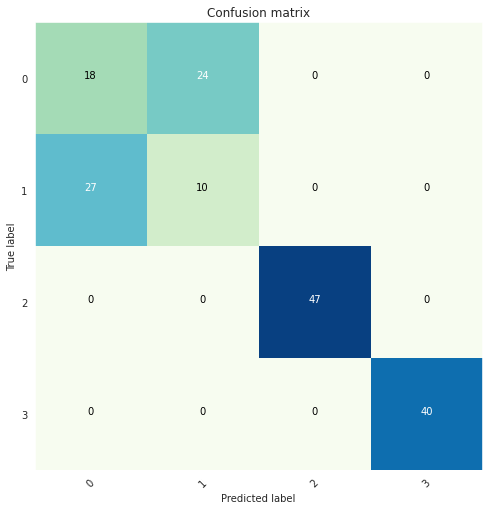

In [38]:
# Visualising the confusion matrix
plot_confusion_mat(pred_test, range(nb_cluster))

### Saving the features

In [ ]:
# Saving the file of PCA features in csv format
csv_buffer = io.StringIO()
df_pca = df_pca100.toPandas()
df_pca.to_csv(csv_buffer)
s3R.Object(BUCKET_NAME, 'df_pca.csv').put(Body=csv_buffer.getvalue())

22/08/16 04:42:26 WARN TaskSetManager: Stage 236 contains a task of very large size (16716 KiB). The maximum recommended task size is 1000 KiB.


22/08/16 04:42:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


{'ResponseMetadata': {'RequestId': 'Y2Y2PCVMVNGPP9GV',
  'HostId': 'J7+g7TXdVfP22GyKQhgWi5Y1lrZGSuyiNI7MZVxldlsgfqWdKaXAqvU0VpyvJiOdNnEURnCu/c8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'J7+g7TXdVfP22GyKQhgWi5Y1lrZGSuyiNI7MZVxldlsgfqWdKaXAqvU0VpyvJiOdNnEURnCu/c8=',
   'x-amz-request-id': 'Y2Y2PCVMVNGPP9GV',
   'date': 'Tue, 16 Aug 2022 04:42:32 GMT',
   'etag': '"1ac4bc21169f61249b2e09fad233bee8"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1ac4bc21169f61249b2e09fad233bee8"'}

The end of the notebook